In [232]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

In [233]:

class Host:
    def __init__(self):
        n_nodes = 6
        
        self.network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)
        
        for node in self.network.nodes:
            self.network.nodes[node]['active'] = 0.5
            
        
        to_detector = [e for e in list(self.network.edges) if e[1] ==0]
        from_effector = [e for e in list(self.network.edges) if e[0] ==n_nodes-1]
        
        self.network.remove_edges_from(from_effector + to_detector + [(0,n_nodes-1)])
        
        for u,v,e in self.network.edges(data=True):
            e['weight'] = 0.5
        
        
    
    def update(self):
        temp = self.network
        
        for node in self.network.nodes:
           """
           to do: loop over all nodes with incoming
           links to each node, check whether they are
           positive or negative, construct the variables
           sum of kij x p*j and sum of lij x p*j
           
           """
        
           pass 
    
    
    def fitness(self):
        """
        formula for fitness
        """
        pass
        
    def mutate(self):
        pass
    
    
    def observe(self):
        edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())
        
        letters = ['D']+(self.network.number_of_nodes()-2)*['S']+['E']
        labels = dict(zip(self.network.nodes,letters))
        
        nx.draw(self.network, node_size=1000,
        with_labels=True, labels = labels,
        cmap= plt.cm.viridis, edge_color=weights,
       width=5) 
        
        
#         return np.exp(-self.network)

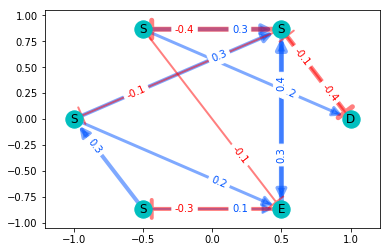

(-0.06427616344671738,
 -0.3755172997895839,
 -0.38469888526620977,
 -0.13772058486657734,
 0.3357358242450148,
 0.1626948870652548,
 0.25145591404661793,
 -0.14044472344084324,
 0.2946025690814479,
 0.18560453827597734,
 0.3056961827508714,
 0.05604628875394624,
 0.3624434389607243,
 -0.29735998797805985)

In [703]:
n_nodes = 6
host_network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)

#to_detector = [e for e in list(host_network.edges) if e[1] ==0]
#from_effector = [e for e in list(host_network.edges) if e[0] ==n_nodes-1]

for node in host_network.nodes:
    host_network.nodes[node]['active'] = 0.5
    




for u,v,e in host_network.edges(data=True):
    e['weight'] = np.random.uniform(-0.5,0.5)

host_network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])

edges,weights = zip(*nx.get_edge_attributes(host_network,'weight').items())

activating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]

deactivating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]
negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]



pos = nx.shell_layout(host_network)

# nx.draw_networkx(host_network, node_size=1000,
#         with_labels=True, labels = dict(zip(host_network.nodes,['D','S','S','S','E'])),
#         edge_cmap= plt.cm.viridis, edge_color=weights,
#        width=4, alpha=0, style='dotdashed') 


        #edge_labels=[e['weight'] for e in host_network.edges] )
nx.draw_networkx_nodes(host_network, node_size=300, pos=pos, alpha=1, 
                       node_color='c')  

graph_act_edges =nx.draw_networkx_edges(host_network, edgelist=activating,
                       pos=pos, width=[10*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                        #edge_cmap= plt.cm.Blues, vmax=1, edge_color=positive_weights,
                        alpha=1)

graph_deact_edges = nx.draw_networkx_edges(host_network, edgelist=deactivating,
                       pos=pos, width=[10*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                        #edge_cmap= plt.cm.Reds, edge_color=negative_weights,
                        alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))

letters = ['D']+(host_network.number_of_nodes()-2)*['S']+['E']
labels = dict(zip(host_network.nodes,letters))

nx.draw_networkx_labels(host_network, pos=pos, 
                       labels = labels)
nx.draw_networkx_edge_labels(host_network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
nx.draw_networkx_edge_labels(host_network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))




ax = plt.gca() # to get the current axis


for e in graph_act_edges+graph_deact_edges:
    pass
    #e.set_edgecolor("k")
    #e.set_linewidth(16)
    #e.set_joinstyle('miter')
    #e.set_connectionstyle('Arc3')
    e.set_alpha(0.5)

plt.show()

weights

In [697]:
#graph_edges
nx.get_edge_attributes(host_network,'weight')

#[node for node in host_network.nodes]
#list(host_network.nodes)[0]

{(0, 2): -0.06475607424153917,
 (0, 3): 0.382103889541231,
 (1, 3): -0.30916043971361973,
 (1, 4): -0.12957567823160165,
 (1, 5): 0.1856627351192447,
 (2, 0): -0.07012656304744902,
 (2, 1): -0.08959887373560615,
 (2, 5): 0.27170626356629024,
 (3, 2): 0.1291968475362848,
 (3, 4): 0.15884696390867492,
 (4, 0): -0.365554191188434,
 (4, 1): -0.19839045406225542,
 (4, 2): -0.33764931748273685,
 (4, 3): 0.1642202419449239,
 (5, 0): 0.2635456978042827}

In [171]:
host_network.remove_edges_from(n_nodes-1)

TypeError: 'int' object is not iterable

In [165]:
list(host_network.neighbors(4))

[]

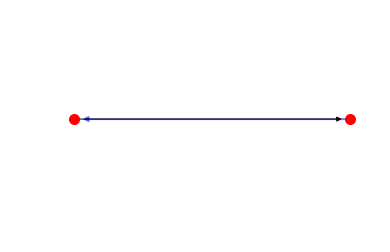

In [331]:
G = nx.DiGraph()
G.add_nodes_from([0,1])
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size = 100, alpha = 1)
nx.draw_networkx_edges(G, pos, edgelist = [(0,1)], width = 2, alpha = 0.5, edge_color='b')
nx.draw_networkx_edges(G, pos, edgelist= [(1,0)], width = 1, alpha = 1)
plt.axis('off')
plt.show() 

In [352]:
#list(host_network.edges.data())

activating = [(u,v) for u,v,d in host_network.edges.data() if d['weight'] > 0]
deactivating =[(u,v) for u,v,d in host_network.edges.data() if d['weight'] < 0]

[(1, 3), (2, 4), (3, 0), (4, 3)]

In [390]:
activating = [(e,w) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
deactivating = [(e,w) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

positive_weights = 
negative_weights = 

In [406]:
np.array([(e,w) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0])

array([[(2, 0), 0.5],
       [(2, 3), 0.5],
       [(4, 2), 0.5],
       [(4, 3), 0.5]], dtype=object)